In [1]:
!pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 31.6 MB/s 


In [2]:
from glob import glob
from sklearn.model_selection import GroupKFold, StratifiedKFold
import cv2
from skimage import io
import os
from datetime import datetime
import time
import random
import cv2
import pandas as pd
import numpy as np
from tqdm import tqdm
from IPython.display import display
import matplotlib.pyplot as plt
import sklearn
import warnings
import joblib
from sklearn.metrics import roc_auc_score, log_loss
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import warnings; warnings.filterwarnings('ignore')
import cv2
import pydicom
#from efficientnet_pytorch import EfficientNet
from scipy.ndimage.interpolation import zoom

import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score

from pylab import rcParams
rcParams['figure.figsize'] = 20,5

In [3]:
!gdown --id 1diztKyKFfhINpY-8R_KB84kV8akW2NjD

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1diztKyKFfhINpY-8R_KB84kV8akW2NjD
To: /content/test_train_val.zip
100% 480M/480M [00:03<00:00, 135MB/s]


In [4]:
!unzip -qq test_train_val.zip

In [5]:
with open('test_train_val/train_meta.csv') as f:
  train_df= pd.read_csv(f)
with open('test_train_val/train_signal.csv') as f:
  train_signal = pd.read_csv(f)

with open('test_train_val/valid_meta.csv') as f:
  valid_df= pd.read_csv(f)
with open('test_train_val/valid_signal.csv') as f:
  valid_signal = pd.read_csv(f)

with open('test_train_val/test_meta.csv') as f:
  test_df= pd.read_csv(f)
with open('test_train_val/test_signal.csv') as f:
  test_signal = pd.read_csv(f)

print(train_df.shape)

train_df

(17441, 37)


,ecg_id,age,sex,height,weight,nurse,site,device,NORM,MI,...,sub_ISC_,sub_SEHYP,sub_ISCI,sub_CRBBB,sub_CLBBB,sub_LAO/LAE,sub_ILBBB,sub_WPW,sub_PMI,strat_fold
0,1,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1,0,...,0,0,0,0,0,0,0,0,0,3
1,2,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1,0,...,0,0,0,0,0,0,0,0,0,2
2,3,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1,0,...,0,0,0,0,0,0,0,0,0,5
3,4,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1,0,...,0,0,0,0,0,0,0,0,0,3
4,5,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1,0,...,0,0,0,0,0,0,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17436,21832,63.0,0,NaN,NaN,1.0,2.0,AT-60 3,0,0,...,0,0,0,0,0,0,0,0,0,7
17437,21833,67.0,1,NaN,NaN,1.0,2.0,AT-60 3,0,0,...,0,0,0,0,0,0,0,0,0,7
17438,21834,93.0,0,NaN,NaN,1.0,2.0,AT-60 3,1,0,...,0,0,0,0,0,0,0,0,0,4
17439,21835,59.0,1,NaN,NaN,1.0,2.0,AT-60 3,0,0,...,0,0,0,0,0,0,0,0,0,2


In [16]:
train_signal

,ecg_id,channel-0,channel-1,channel-2,channel-3,channel-4,channel-5,channel-6,channel-7,channel-8,channel-9,channel-10,channel-11
0,1,-0.119,-0.055,0.064,0.086,-0.091,0.004,-0.069,-0.031,0.000,-0.026,-0.039,-0.079
1,1,-0.116,-0.051,0.065,0.083,-0.090,0.006,-0.064,-0.036,-0.003,-0.031,-0.034,-0.074
2,1,-0.120,-0.044,0.076,0.082,-0.098,0.016,-0.058,-0.034,-0.010,-0.028,-0.029,-0.069
3,1,-0.117,-0.038,0.080,0.077,-0.098,0.021,-0.050,-0.030,-0.015,-0.023,-0.022,-0.064
4,1,-0.103,-0.031,0.072,0.066,-0.087,0.021,-0.045,-0.027,-0.020,-0.019,-0.018,-0.058
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17440995,21836,0.096,0.189,0.093,-0.143,0.001,0.141,-0.034,0.189,0.162,0.227,0.183,0.128
17440996,21836,0.051,0.119,0.068,-0.085,-0.009,0.093,-0.049,0.195,0.172,0.217,0.127,0.081
17440997,21836,0.033,0.070,0.037,-0.052,-0.002,0.054,-0.097,0.140,0.215,0.218,0.101,0.052
17440998,21836,0.027,0.082,0.055,-0.055,-0.014,0.068,-0.104,0.123,0.200,0.210,0.335,0.010


In [6]:
class PTBXLDatasetPreprocesser():
    def __init__(self):
        pass
    
    def save(self, filename):
        data = {
            'superclass_cols': self.superclass_cols,
            'subclass_cols': self.subclass_cols,
            'meta_num_cols': self.meta_num_cols,
            'meta_num_means': self.meta_num_means,
            'min_max_scaler': self.min_max_scaler,
            'meta_cat_cols': self.meta_cat_cols,
            'cat_lablers': self.cat_lablers,
            'bclass_cols': self.bclass_cols,
            
        }
        pd.to_pickle(data, filename)
        
    def load(self, filename):
        data = pd.read_pickle(filename)
        self.min_max_scaler = data['min_max_scaler']
        self.cat_lablers = data['cat_lablers']
        #self.binary_lablers = data['binary_lablers']
        
    def fit(self, x, y):
        x = x.copy()
        y = y.copy()
        
        self.superclass_cols = [ 'MI', 'STTC', 'CD', 'HYP']
        
        self.subclass_cols = [col for col in y.columns if 'sub_' in col]

        self.bclass_cols = ['NORM']
        
        self.meta_num_cols = ['age', 'height', 'weight']
        self.meta_num_means = []
        for col in self.meta_num_cols:
            print(col, y[col].mean())
            y[col] = y[col].fillna(y[col].mean())
            self.meta_num_means += [y[col].mean()]
            
        self.min_max_scaler = MinMaxScaler().fit(y[self.meta_num_cols])
        
        self.meta_cat_cols = ['sex'] #, 'nurse', 'device']
        self.cat_lablers = [LabelEncoder().fit(y[col].fillna('none').astype(str)) for col in self.meta_cat_cols]
        return self

        #self.min_max_scaler = MinMaxScaler().fit(y[self.meta_num_cols])
        
        #self.meta_binary_cols = ['NORM'] 
        #self.binary_lablers = [LabelEncoder().fit(y[col].fillna('none').astype(str)) for col in self.meta_binary_cols]
        #return self
    
    def transform(self, x, y):
        
        channel_cols = x.columns.tolist()[1:]
        
        ret = []
        x = x[channel_cols].values.reshape(-1, 1000, 12)
        print(x.shape)
        ret += [x] # signal
        
        y_ = y.copy()
        
        for i, col in enumerate(self.meta_num_cols):
            y_[col] = y_[col].fillna(self.meta_num_means[i])
        y_[self.meta_num_cols] = self.min_max_scaler.transform(y_[self.meta_num_cols])
        y_[self.meta_num_cols] = np.clip(y_[self.meta_num_cols], 0., 1.) # prevent extreme value far from train set
        
        ret += [y_[self.meta_num_cols]] # meta num features
        
        for i, col in enumerate(self.meta_cat_cols):
            y_[col] = y_[col].fillna('none').astype(str)
            y_[col] = self.cat_lablers[i].transform(y_[col]) 
        
        ret += [y_[self.meta_cat_cols]] # meta cat features

        #for i, col in enumerate(self.meta_binary_cols):
           # y_[col] = y_[col].fillna('none').astype(str)
           # y_[col] = self.binary_lablers[i].transform(y_[col]) 
        
        #ret += [y_[self.meta_binary_cols]] # binary class target
        
        if np.isin(self.superclass_cols, y.columns).sum() == len(self.superclass_cols):
            ret += [y[self.superclass_cols].fillna(0).astype(int)] # superclass targets
        
        if np.isin(self.subclass_cols, y.columns).sum() == len(self.subclass_cols):
            ret += [y[self.subclass_cols].fillna(0).astype(int)] # subclass targets

        if np.isin(self.bclass_cols, y.columns).sum() == len(self.bclass_cols):
            ret += [y[self.bclass_cols].fillna(0).astype(int)]
        
        return ret

In [7]:
data_preprocessor = PTBXLDatasetPreprocesser()
data_preprocessor.fit(train_signal, train_df)
train_signal, train_meta_num_feats, train_meta_cat_feats, train_superclass, train_subclass, train_bclass = data_preprocessor.transform(train_signal, train_df)
valid_signal, valid_meta_num_feats, valid_meta_cat_feats, valid_superclass, valid_subclass, valid_bclass = data_preprocessor.transform(valid_signal, valid_df)
test_signal, test_meta_num_feats, test_meta_cat_feats, test_superclass, test_subclass, test_bclass = data_preprocessor.transform(test_signal, test_df)

print(train_signal.shape)
print(valid_meta_num_feats.isna().sum(), valid_meta_cat_feats.isna().sum(), valid_superclass.isna().sum(), valid_subclass.isna().sum(), valid_bclass.isna().sum())

display(train_meta_num_feats)
display(train_meta_cat_feats)
display(train_superclass)
display(train_subclass)
display(train_bclass)

age 59.63709074169975
height 166.68908469699693
weight 70.69599447513812
(17441, 1000, 12)
(2193, 1000, 12)
(2203, 1000, 12)
(17441, 1000, 12)
age       0
height    0
weight    0
dtype: int64 sex    0
dtype: int64 MI      0
STTC    0
CD      0
HYP     0
dtype: int64 sub_NORM         0
sub_IMI          0
sub_STTC         0
sub_NST_         0
sub_LVH          0
sub_LAFB/LPFB    0
sub_RVH          0
sub_RAO/RAE      0
sub_IRBBB        0
sub_IVCD         0
sub_LMI          0
sub_AMI          0
sub__AVB         0
sub_ISCA         0
sub_ISC_         0
sub_SEHYP        0
sub_ISCI         0
sub_CRBBB        0
sub_CLBBB        0
sub_LAO/LAE      0
sub_ILBBB        0
sub_WPW          0
sub_PMI          0
dtype: int64 NORM    0
dtype: int64


,age,height,weight
0,0.580645,0.791572,0.282927
1,0.182796,0.791572,0.317073
2,0.376344,0.791572,0.312195
3,0.236559,0.791572,0.375610
4,0.182796,0.791572,0.317073
...,...,...,...
17436,0.655914,0.791572,0.320468
17437,0.698925,0.791572,0.320468
17438,0.978495,0.791572,0.320468
17439,0.612903,0.791572,0.320468


,sex
0,1
1,0
2,1
3,0
4,1
...,...
17436,0
17437,1
17438,0
17439,1


,MI,STTC,CD,HYP
0,0,0,0,0
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0
...,...,...,...,...
17436,0,0,1,0
17437,0,1,0,0
17438,0,0,0,0
17439,0,1,0,0


,sub_NORM,sub_IMI,sub_STTC,sub_NST_,sub_LVH,sub_LAFB/LPFB,sub_RVH,sub_RAO/RAE,sub_IRBBB,sub_IVCD,...,sub_ISCA,sub_ISC_,sub_SEHYP,sub_ISCI,sub_CRBBB,sub_CLBBB,sub_LAO/LAE,sub_ILBBB,sub_WPW,sub_PMI
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17436,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
17437,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17438,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17439,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


,NORM
0,1
1,1
2,1
3,1
4,1
...,...
17436,0
17437,0
17438,1
17439,0


In [9]:
#new_df= np.hstack((train_meta_num_feats, train_meta_cat_feats))
#new_df.shape
#new_
train_signal.head()

AttributeError: ignored

In [8]:
signal=np.array(train_signal)
signal.shape
#print(signal)

(17441, 1000, 12)

In [ ]:
newsignal= signal.reshape(17441,10,100,12)


In [9]:
target=np.array(train_bclass)
target.shape

(17441, 1)

In [10]:
v_signal=np.array(valid_signal)

In [11]:
v_signal.shape

(2193, 1000, 12)

In [ ]:
#newv_signal=v_signal.reshape(2193,10,100,12)

In [12]:
v_target=np.array(valid_bclass)
v_target.shape

(2193, 1)

In [13]:
!pip install ecg-plot
#import physionet_challenge_utility_script as pc
import ecg_plot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras.utils.vis_utils import plot_model
#from keras.utils import plot_model
#from keras.preprocessing.sequence import pad_sequences
from keras import layers
from keras.layers import Input, Dense, Dropout, Activation, BatchNormalization, Add
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPool1D, ZeroPadding1D, LSTM, Bidirectional, ConvLSTM1D
from keras.models import Sequential, Model
#from keras.utils import plot_model
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
from keras.layers import concatenate
from scipy import optimize
from scipy.io import loadmat
import os
%load_ext autoreload
%autoreload
%reload_ext autoreload

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_AUC', factor=0.1, patience=1, verbose=1, mode='max',
    min_delta=0.0001, cooldown=0, min_lr=0
)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_AUC', mode='max', verbose=1, patience=2)

**Binary Classification on ECG ataset**

**ANN MODEL**

In [ ]:
ann_model = Sequential()
ann_model.add(Dense(50, activation='relu', input_shape=(1000,12)))
ann_model.add(Dense(50, activation='relu'))
ann_model.add(Dense(50, activation='relu'))
ann_model.add(Dense(50, activation='relu'))
ann_model.add(GlobalAveragePooling1D())
ann_model.add(Dense(1, activation='sigmoid'))

In [ ]:
ann_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=[tf.keras.metrics.BinaryAccuracy(
        name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),tf.keras.metrics.Precision(name='Precision'), 
                    tf.keras.metrics.AUC(
        num_thresholds=200,
        curve="ROC",
        summation_method="interpolation",
        name="AUC",
        dtype=None,
        thresholds=None,
        multi_label=True,
        label_weights=None,
    )])

In [ ]:
ann_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics='accuracy')

In [ ]:
ann_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 1000, 50)          650       
                                                                 
 dense_9 (Dense)             (None, 1000, 50)          2550      
                                                                 
 dense_10 (Dense)            (None, 1000, 50)          2550      
                                                                 
 dense_11 (Dense)            (None, 1000, 50)          2550      
                                                                 
 global_average_pooling1d_2   (None, 50)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_12 (Dense)            (None, 1)                 51        
                                                      

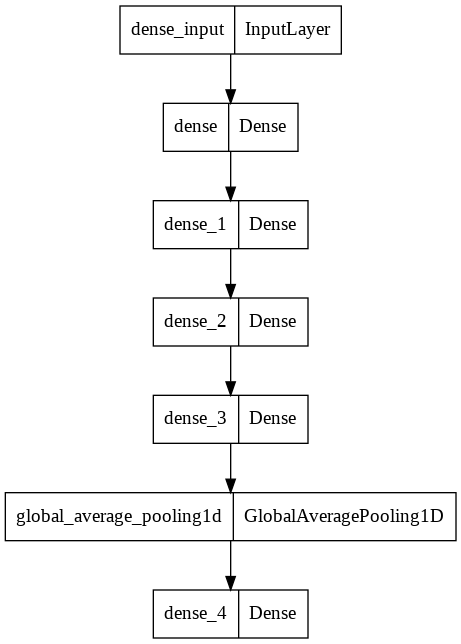

In [ ]:
plot_model(ann_model)

In [ ]:
batchsize = 20
ann_model.fit(x=signal, y=target, batch_size=batchsize, epochs=30, verbose='auto', callbacks=[reduce_lr,early_stop], validation_data=(v_signal,v_target))

Epoch 1/30
873/873 [==============================] - 17s 18ms/step - loss: 0.6524 - accuracy: 0.5996 - Recall: 0.1518 - Precision: 0.6851 - AUC: 0.7061 - val_loss: 0.5892 - val_accuracy: 0.7114 - val_Recall: 0.4723 - val_Precision: 0.7793 - val_AUC: 0.8110 - lr: 1.0000e-04
Epoch 2/30
873/873 [==============================] - 8s 9ms/step - loss: 0.5643 - accuracy: 0.7304 - Recall: 0.6357 - Precision: 0.7146 - AUC: 0.8022 - val_loss: 0.5237 - val_accuracy: 0.7396 - val_Recall: 0.6499 - val_Precision: 0.7249 - val_AUC: 0.8255 - lr: 1.0000e-04
Epoch 3/30
873/873 [==============================] - 8s 10ms/step - loss: 0.5298 - accuracy: 0.7434 - Recall: 0.6891 - Precision: 0.7130 - AUC: 0.8209 - val_loss: 0.5062 - val_accuracy: 0.7515 - val_Recall: 0.6980 - val_Precision: 0.7229 - val_AUC: 0.8360 - lr: 1.0000e-04
Epoch 4/30
873/873 [==============================] - 8s 10ms/step - loss: 0.5107 - accuracy: 0.7547 - Recall: 0.7091 - Precision: 0.7232 - AUC: 0.8335 - val_loss: 0.4935 - val_a

Text(0, 0.5, 'Accuracy')

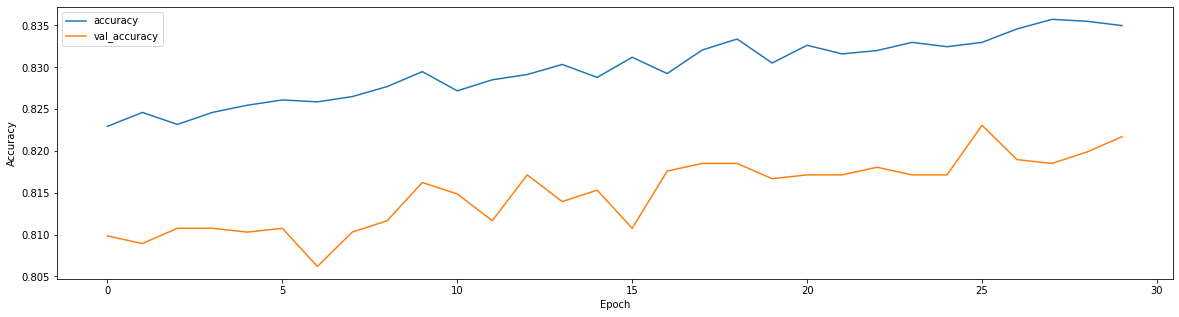

In [ ]:
plt.plot(ann_model.history.history['accuracy'])
# plt.plot(ann_model.history.history['Precision'])
plt.plot(ann_model.history.history['val_accuracy'])
# plt.plot(ann_model.history.history['val_Precision'])
plt.legend(("accuracy","val_accuracy"))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

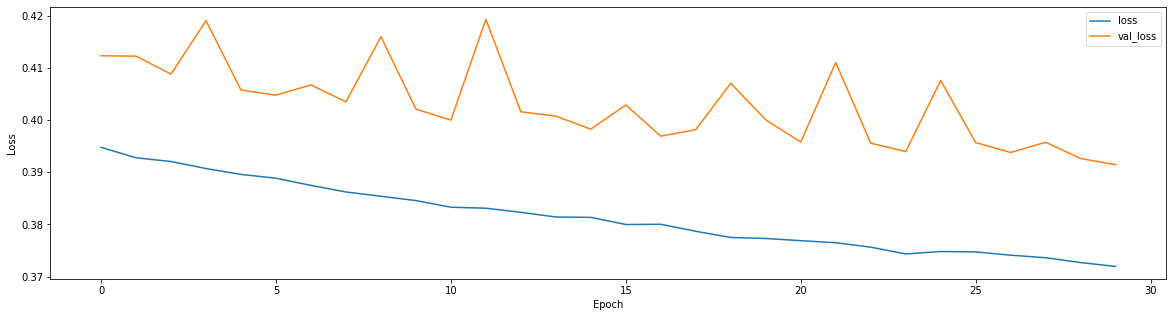

In [ ]:
plt.plot(ann_model.history.history['loss'])
plt.plot(ann_model.history.history['val_loss'])
plt.legend(("loss","val_loss"))
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [ ]:
# plt.plot(ann_model.history.history['Recall'])
# plt.plot(ann_model.history.history['Precision'])
# plt.plot(ann_model.history.history['AUC'])
# plt.legend(("Recall","Precision","AUC"))
# plt.xlabel('Epoch')

In [ ]:
y_pred=ann_model.predict(test_signal)
predict=[int(x+0.5) for x in y_pred]
conf_mat=confusion_matrix(test_bclass,predict)
print(conf_mat)

[[900 339]
 [120 844]]


In [ ]:
accuracy_score(test_bclass,predict)

0.7916477530640036

**CNN MODEL**

**Lenet-5 model**

In [ ]:
lenet_5_model=Sequential()

lenet_5_model.add(Conv1D(filters=6, kernel_size=3, padding='same', input_shape=(1000,12)))
lenet_5_model.add(BatchNormalization())
lenet_5_model.add(Activation('relu'))
lenet_5_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

lenet_5_model.add(Conv1D(filters=16, strides=1, kernel_size=5))
lenet_5_model.add(BatchNormalization())
lenet_5_model.add(Activation('relu'))
lenet_5_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

lenet_5_model.add(GlobalAveragePooling1D())

lenet_5_model.add(Dense(64, activation='relu'))

lenet_5_model.add(Dense(32, activation='relu'))

lenet_5_model.add(Dense(1, activation = 'sigmoid'))

In [ ]:
lenet_5_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=[tf.keras.metrics.BinaryAccuracy(
        name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),tf.keras.metrics.Precision(name='Precision'), 
                    tf.keras.metrics.AUC(
        num_thresholds=200,
        curve="ROC",
        summation_method="interpolation",
        name="AUC",
        dtype=None,
        thresholds=None,
        multi_label=True,
        label_weights=None,
    )])

In [ ]:
lenet_5_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1000, 6)           222       
                                                                 
 batch_normalization (BatchN  (None, 1000, 6)          24        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 1000, 6)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 500, 6)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 496, 16)           496       
                                                                 
 batch_normalization_1 (Batc  (None, 496, 16)         

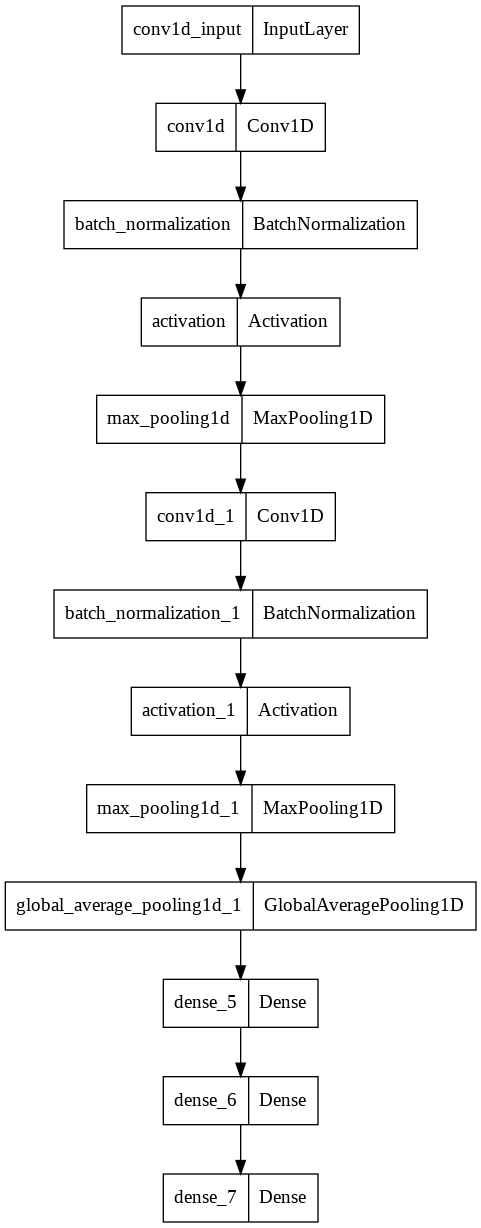

In [ ]:
plot_model(lenet_5_model)

In [ ]:
batchsize = 5
lenet_5_model.fit(x=signal, y=target, batch_size=batchsize, epochs=10, verbose='auto', callbacks=None, validation_split=0.2, validation_data=(v_signal,v_target), shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None)

Epoch 1/10
2791/2791 [==============================] - 46s 13ms/step - loss: 0.5104 - accuracy: 0.7456 - Recall: 0.7322 - Precision: 0.7142 - AUC: 0.8246 - val_loss: 0.4136 - val_accuracy: 0.8166 - val_Recall: 0.7300 - val_Precision: 0.7598 - val_AUC: 0.8921
Epoch 2/10
1068/2791 [==========>...................] - ETA: 17s - loss: 0.4630 - accuracy: 0.7861 - Recall: 0.7830 - Precision: 0.7497 - AUC: 0.8593

KeyboardInterrupt: ignored

In [ ]:
plt.plot(lenet_5_model.history.history['accuracy'])
plt.plot(lenet_5_model.history.history['Precision'])
plt.plot(lenet_5_model.history.history['val_accuracy'])
plt.plot(lenet_5_model.history.history['val_Precision'])
plt.legend(("accuracy","precision","val_accuracy","val_Precision"))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

In [ ]:
plt.plot(lenet_5_model.history.history['loss'])
plt.plot(lenet_5_model.history.history['val_loss'])
plt.legend(("loss","val_loss"))
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [ ]:
plt.plot(lenet_5_model.history.history['Recall'])
plt.plot(lenet_5_model.history.history['Precision'])
plt.plot(lenet_5_model.history.history['AUC'])
plt.legend(("Recall","Precision","AUC"))
plt.xlabel('Epoch')

In [ ]:
y_pred=lenet_5_model.predict(test_signal)
y_pred=np.argmax(y_pred, axis=1)
conf_mat=confusion_matrix(test_bclass,y_pred)
print(conf_mat)

**AlexNet model**

In [ ]:
alexNet_model=Sequential()

alexNet_model.add(Conv1D(filters=96, kernel_size=11, strides=4, input_shape=(1000,12)))
alexNet_model.add(BatchNormalization())
alexNet_model.add(Activation('relu'))
alexNet_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

alexNet_model.add(Conv1D(filters=256, kernel_size=5, padding='same'))
alexNet_model.add(BatchNormalization())
alexNet_model.add(Activation('relu'))
alexNet_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

alexNet_model.add(Conv1D(filters=384, padding='same', kernel_size=3))
alexNet_model.add(BatchNormalization())
alexNet_model.add(Activation('relu'))
alexNet_model.add(Conv1D(filters=384, kernel_size=3))
alexNet_model.add(BatchNormalization())
alexNet_model.add(Activation('relu'))
alexNet_model.add(Conv1D(filters=256, kernel_size=3))
alexNet_model.add(BatchNormalization())
alexNet_model.add(Activation('relu'))
alexNet_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

alexNet_model.add(GlobalAveragePooling1D())
alexNet_model.add(Dense(128, activation='relu'))
alexNet_model.add(Dropout(0.4))
alexNet_model.add(Dense(128, activation='relu'))
alexNet_model.add(Dropout(0.4))
alexNet_model.add(Dense(1, activation='sigmoid'))

In [ ]:
alexNet_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=[tf.keras.metrics.BinaryAccuracy(
        name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),tf.keras.metrics.Precision(name='Precision'), 
                    tf.keras.metrics.AUC(
        num_thresholds=200,
        curve="ROC",
        summation_method="interpolation",
        name="AUC",
        dtype=None,
        thresholds=None,
        multi_label=True,
        label_weights=None,
    )])

In [ ]:
alexNet_model.summary()

In [ ]:
plot_model(alexNet_model)

In [ ]:
batchsize = 16
alexNet_model.fit(x=signal, y=target, batch_size=batchsize, epochs=30, verbose='auto', callbacks=None, validation_split=0.2, validation_data=(v_signal,v_target), shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None)

In [ ]:
plt.plot(alexNet_model.history.history['accuracy'])
plt.plot(alexNet_model.history.history['Precision'])
plt.plot(alexNet_model.history.history['val_accuracy'])
plt.plot(alexNet_model.history.history['val_Precision'])
plt.legend(("accuracy","precision","val_accuracy","val_Precision"))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

In [ ]:
plt.plot(alexNet_model.history.history['loss'])
plt.plot(alexNet_model.history.history['val_loss'])
plt.legend(("loss","val_loss"))
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [ ]:
plt.plot(alexNet_model.history.history['Recall'])
plt.plot(alexNet_model.history.history['Precision'])
plt.plot(alexNet_model.history.history['AUC'])
plt.legend(("Recall","Precision","AUC"))
plt.xlabel('Epoch')

**VGG 16**

In [ ]:
vgg_16_model=Sequential()

vgg_16_model.add(Conv1D(filters=64, kernel_size=3, padding='same',  input_shape=(1000,12)))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(Conv1D(filters=64, kernel_size=3, padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

vgg_16_model.add(Conv1D(filters=128, kernel_size=3, padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(Conv1D(filters=128, kernel_size=3, padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

vgg_16_model.add(Conv1D(filters=256, kernel_size=3, padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(Conv1D(filters=256, kernel_size=3, padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(Conv1D(filters=256, kernel_size=3, padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

vgg_16_model.add(Conv1D(filters=512, kernel_size=3, padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(Conv1D(filters=512, kernel_size=3, padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(Conv1D(filters=512, kernel_size=3, padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

vgg_16_model.add(Conv1D(filters=512, kernel_size=3, padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(Conv1D(filters=512, kernel_size=1, padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(Conv1D(filters=512, kernel_size=1, padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

vgg_16_model.add(GlobalAveragePooling1D())
vgg_16_model.add(Dense(256, activation='relu'))
vgg_16_model.add(Dropout(0.4))
vgg_16_model.add(Dense(128, activation='relu'))
vgg_16_model.add(Dropout(0.4))
vgg_16_model.add(Dense(1, activation='sigmoid'))

In [ ]:
 vgg_16_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=[tf.keras.metrics.BinaryAccuracy(
        name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),tf.keras.metrics.Precision(name='Precision'), 
                    tf.keras.metrics.AUC(
        num_thresholds=200,
        curve="ROC",
        summation_method="interpolation",
        name="AUC",
        dtype=None,
        thresholds=None,
        multi_label=True,
        label_weights=None,
    )])

In [ ]:
vgg_16_model.summary()

In [ ]:
plot_model(vgg_16_model)

In [ ]:
batchsize = 16
vgg_16_model.fit(x=signal, y=target, batch_size=batchsize, epochs=30, verbose='auto', callbacks=None, validation_split=0.2, validation_data=(v_signal,v_target), shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None)

In [ ]:
plt.plot(vgg_16_model.history.history['accuracy'])
plt.plot(vgg_16_model.history.history['Precision'])
plt.plot(vgg_16_model.history.history['val_accuracy'])
plt.plot(vgg_16_model.history.history['val_Precision'])
plt.legend(("accuracy","precision","val_accuracy","val_Precision"))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

In [ ]:
plt.plot(vgg_16_model.history.history['loss'])
plt.plot(vgg_16_model.history.history['val_loss'])
plt.legend(("loss","val_loss"))
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [ ]:
plt.plot(vgg_16_model.history.history['Recall'])
plt.plot(vgg_16_model.history.history['Precision'])
plt.plot(vgg_16_model.history.history['AUC'])
plt.legend(("Recall","Precision","AUC"))
plt.xlabel('Epoch')

**Resnet 50 Model**

In [14]:
def identity_block(X, f, filters):
    F1, F2, F3 = filters
    
    X_shortcut = X
    
    X = Conv1D(filters = F1, kernel_size = 1, activation='relu', strides = 1, padding = 'valid')(X)
    X = BatchNormalization()(X)
    
    X = Conv1D(filters = F2, kernel_size = f, activation='relu', strides = 1, padding = 'same')(X)
    X = BatchNormalization()(X)

    X = Conv1D(filters = F3, kernel_size = 1, activation='relu', strides = 1, padding = 'valid')(X)
    X = BatchNormalization()(X)

    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    return X

def convolutional_block(X, f, filters, s = 2):
    F1, F2, F3 = filters
    
    X_shortcut = X

    X = Conv1D(F1, 1, activation='relu', strides = s)(X)
    X = BatchNormalization()(X)
    
    X = Conv1D(F2, f, activation='relu', strides = 1,padding = 'same')(X)
    X = BatchNormalization()(X)

    X = Conv1D(F3, 1, strides = 1)(X)
    X = BatchNormalization()(X)

    X_shortcut = Conv1D(F3, 1, strides = s)(X_shortcut)
    X_shortcut = BatchNormalization()(X_shortcut)
    
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    return X

def ResNet50(input_shape):
    
    X_input = Input(input_shape)

    X = ZeroPadding1D(3)(X_input)
    
    X = Conv1D(64, 7, strides = 2)(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = MaxPool1D(pool_size=2, strides=2, padding='same')(X)

    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])

    X = convolutional_block(X, f = 3, filters = [128,128,512], s = 2)
    X = identity_block(X, 3, [128,128,512])
    X = identity_block(X, 3, [128,128,512])
    X = identity_block(X, 3, [128,128,512])

    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2)
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])

    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2)
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])

    X = MaxPool1D(pool_size=2, strides=2, padding='same')(X)
    
    X = GlobalAveragePooling1D()(X)
    X = Dense(1,activation='sigmoid')(X)
    
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [15]:
resNet50_model = ResNet50(input_shape = (1000,12))

In [16]:
resNet50_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=[tf.keras.metrics.BinaryAccuracy(
        name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),tf.keras.metrics.Precision(name='Precision'), 
                    tf.keras.metrics.AUC(
        num_thresholds=200,
        curve="ROC",
        summation_method="interpolation",
        name="AUC",
        dtype=None,
        thresholds=None,
        multi_label=True,
        label_weights=None,
    )])

In [17]:
resNet50_model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1000, 12)]   0           []                               
                                                                                                  
 zero_padding1d (ZeroPadding1D)  (None, 1006, 12)    0           ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 500, 64)      5440        ['zero_padding1d[0][0]']         
                                                                                                  
 batch_normalization (BatchNorm  (None, 500, 64)     256         ['conv1d[0][0]']                 
 alization)                                                                                

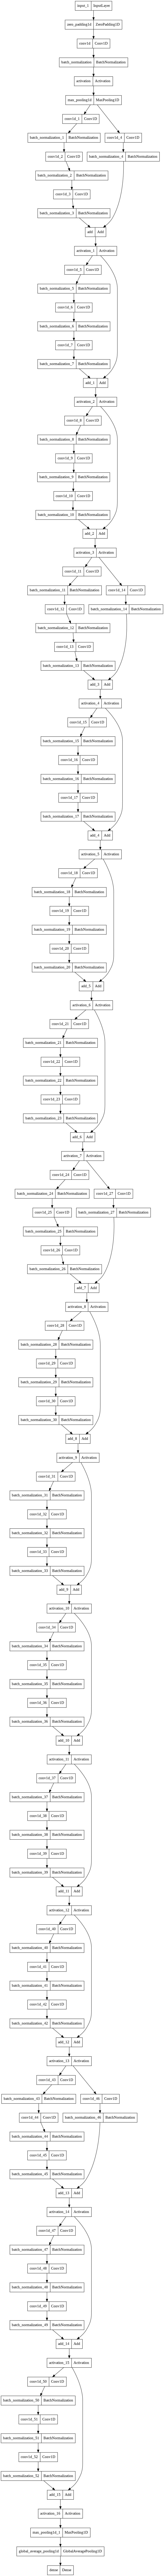

In [18]:
plot_model(resNet50_model)

In [ ]:
batchsize = 16
resNet50_model.fit(x=signal, y=target, batch_size=batchsize, epochs=30, verbose='auto', callbacks=None, validation_split=0.2, validation_data=(v_signal,v_target), shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None)

In [ ]:
plt.plot(resNet50_model.history.history['accuracy'])
plt.plot(resNet50_model.history.history['Precision'])
plt.plot(resNet50_model.history.history['val_accuracy'])
plt.plot(resNet50_model.history.history['val_Precision'])
plt.legend(("accuracy","precision","val_accuracy","val_Precision"))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

In [ ]:
plt.plot(resNet50_model.history.history['loss'])
plt.plot(resNet50_model.history.history['val_loss'])
plt.legend(("loss","val_loss"))
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [ ]:
plt.plot(resNet50_model.history.history['Recall'])
plt.plot(resNet50_model.history.history['Precision'])
plt.plot(resNet50_model.history.history['AUC'])
plt.legend(("Recall","Precision","AUC"))
plt.xlabel('Epoch')

**Inseption Model**

In [19]:
def inception_block(prev_layer):
    
    conv1=Conv1D(filters = 64, kernel_size = 1, padding = 'same')(prev_layer)
    conv1=BatchNormalization()(conv1)
    conv1=Activation('relu')(conv1)
    
    conv3=Conv1D(filters = 64, kernel_size = 1, padding = 'same')(prev_layer)
    conv3=BatchNormalization()(conv3)
    conv3=Activation('relu')(conv3)
    conv3=Conv1D(filters = 64, kernel_size = 3, padding = 'same')(conv3)
    conv3=BatchNormalization()(conv3)
    conv3=Activation('relu')(conv3)
    
    conv5=Conv1D(filters = 64, kernel_size = 1, padding = 'same')(prev_layer)
    conv5=BatchNormalization()(conv5)
    conv5=Activation('relu')(conv5)
    conv5=Conv1D(filters = 64, kernel_size = 5, padding = 'same')(conv5)
    conv5=BatchNormalization()(conv5)
    conv5=Activation('relu')(conv5)
    
    pool= MaxPool1D(pool_size=3, strides=1, padding='same')(prev_layer)
    convmax=Conv1D(filters = 64, kernel_size = 1, padding = 'same')(pool)
    convmax=BatchNormalization()(convmax)
    convmax=Activation('relu')(convmax)
    
    layer_out = concatenate([conv1, conv3, conv5, convmax], axis=1)
    
    return layer_out

def inception_model(input_shape):
    X_input=Input(input_shape)
    
    X = ZeroPadding1D(3)(X_input)
    
    X = Conv1D(filters = 64, kernel_size = 7, padding = 'same')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = MaxPool1D(pool_size=3, strides=2, padding='same')(X)
    
    X = Conv1D(filters = 64, kernel_size = 1, padding = 'same')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    X = inception_block(X)
    X = inception_block(X)
    
    X = MaxPool1D(pool_size=7, strides=2, padding='same')(X)
    
    X = GlobalAveragePooling1D()(X)
    X = Dense(1,activation='sigmoid')(X)
    
    model = Model(inputs = X_input, outputs = X, name='Inception')
    
    return model

In [20]:
inception_model = inception_model(input_shape = (1000,12))

In [21]:
inception_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=[tf.keras.metrics.BinaryAccuracy(
        name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),tf.keras.metrics.Precision(name='Precision'), 
                    tf.keras.metrics.AUC(
        num_thresholds=200,
        curve="ROC",
        summation_method="interpolation",
        name="AUC",
        dtype=None,
        thresholds=None,
        multi_label=True,
        label_weights=None,
    )])

In [22]:
inception_model.summary()

Model: "Inception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1000, 12)]   0           []                               
                                                                                                  
 zero_padding1d_1 (ZeroPadding1  (None, 1006, 12)    0           ['input_2[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1d_53 (Conv1D)             (None, 1006, 64)     5440        ['zero_padding1d_1[0][0]']       
                                                                                                  
 batch_normalization_53 (BatchN  (None, 1006, 64)    256         ['conv1d_53[0][0]']      

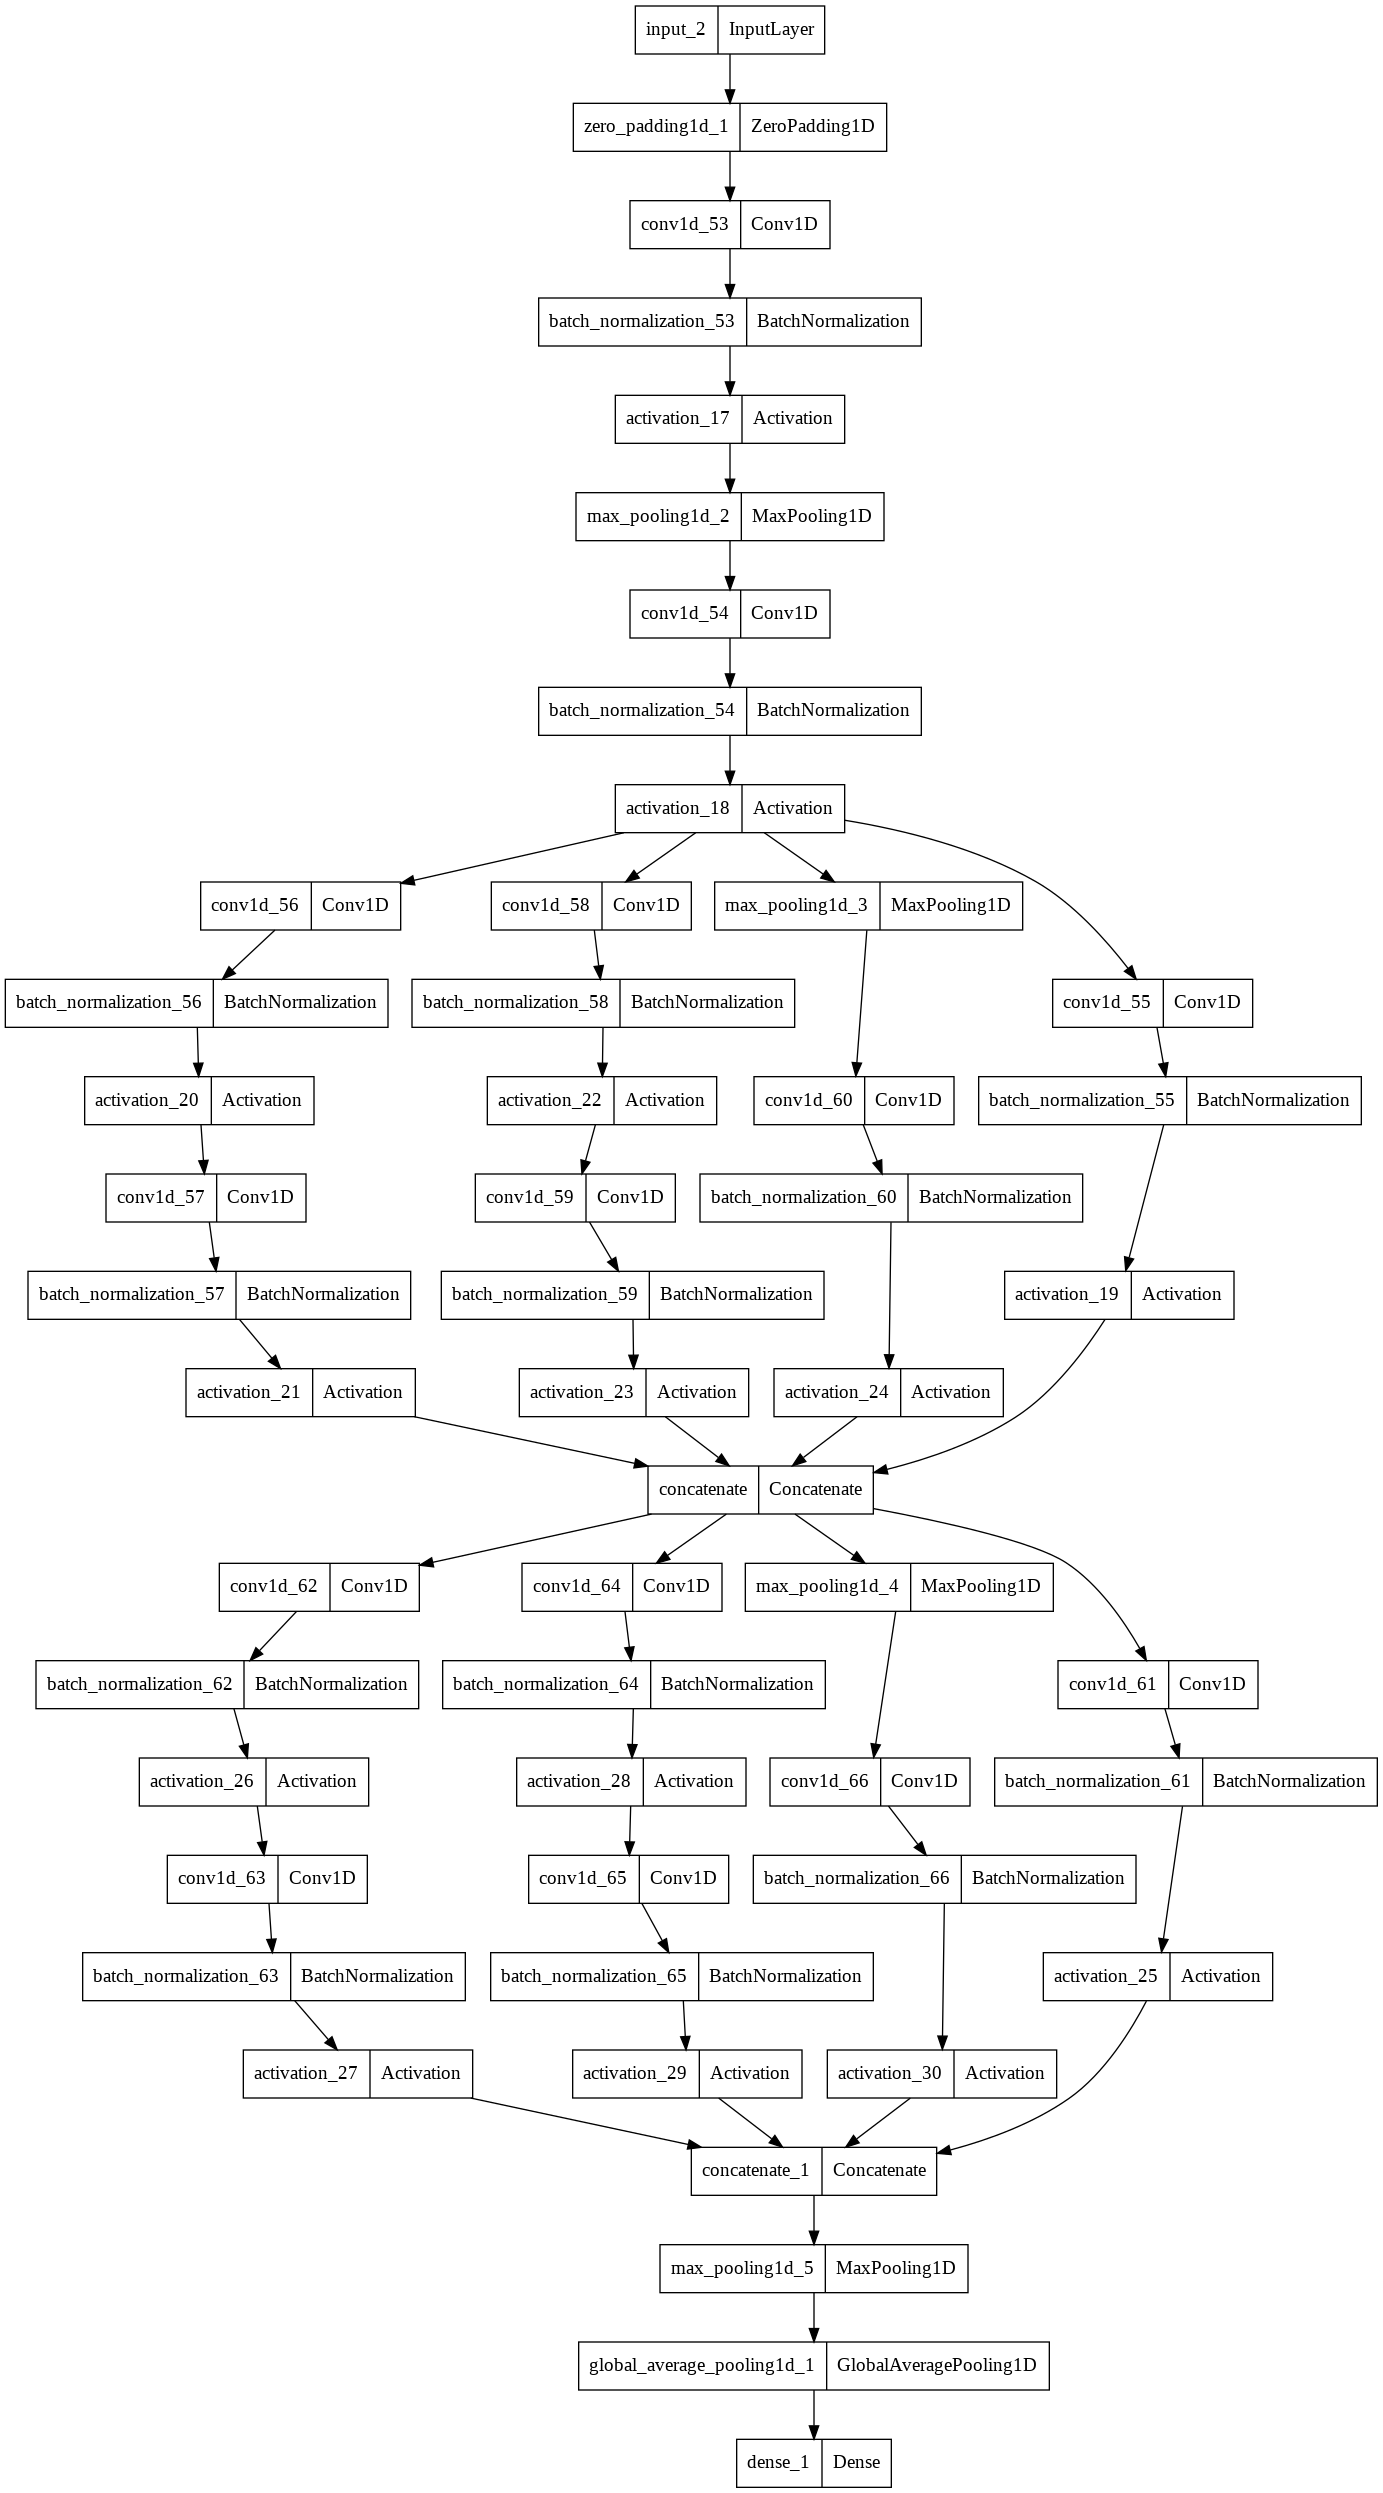

In [23]:
plot_model(inception_model)

In [ ]:
batchsize = 16
inception_model.fit(x=signal, y=target, batch_size=batchsize, epochs=30, verbose='auto', callbacks=None, validation_split=0.2, validation_data=(v_signal,v_target), shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None)

In [ ]:
plt.plot(inception_model.history.history['accuracy'])
plt.plot(inception_model.history.history['Precision'])
plt.plot(inception_model.history.history['val_accuracy'])
plt.plot(inception_model.history.history['val_Precision'])
plt.legend(("accuracy","precision","val_accuracy","val_Precision"))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

In [ ]:
plt.plot(inception_model.history.history['loss'])
plt.plot(inception_model.history.history['val_loss'])
plt.legend(("loss","val_loss"))
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [ ]:
plt.plot(inception_model.history.history['Recall'])
plt.plot(inception_model.history.history['Precision'])
plt.plot(inception_model.history.history['AUC'])
plt.legend(("Recall","Precision","AUC"))
plt.xlabel('Epoch')

**RNN Models**

**LSTM Model**

In [24]:
lstm_model = Sequential()
lstm_model.add(LSTM(64, input_shape=(1000,12), return_sequences=True))
lstm_model.add(LSTM(64))
lstm_model.add(Dense(32, activation = 'relu'))
lstm_model.add(Dropout(0.3))
lstm_model.add(Dense(1, activation = 'sigmoid'))

In [25]:
 lstm_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=[tf.keras.metrics.BinaryAccuracy(
        name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),tf.keras.metrics.Precision(name='Precision'), 
                    tf.keras.metrics.AUC(
        num_thresholds=200,
        curve="ROC",
        summation_method="interpolation",
        name="AUC",
        dtype=None,
        thresholds=None,
        multi_label=True,
        label_weights=None,
    )])

In [26]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1000, 64)          19712     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 54,849
Trainable params: 54,849
Non-trainable params: 0
_________________________________________________________________


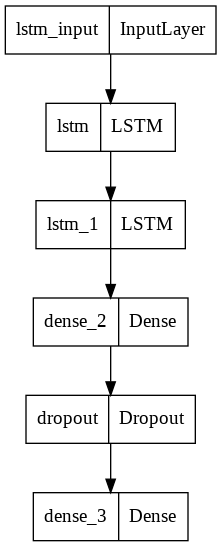

In [27]:
plot_model(lstm_model)

In [ ]:
batchsize = 16
lstm_model.fit(x=signal, y=target, batch_size=batchsize, epochs=30, verbose='auto', callbacks=None, validation_split=0.2, validation_data=(v_signal,v_target), shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None)

In [ ]:
plt.plot(lstm_model.history.history['accuracy'])
plt.plot(lstm_model.history.history['Precision'])
plt.plot(lstm_model.history.history['val_accuracy'])
plt.plot(lstm_model.history.history['val_Precision'])
plt.legend(("accuracy","precision","val_accuracy","val_Precision"))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

In [ ]:
plt.plot(lstm_model.history.history['loss'])
plt.plot(lstm_model.history.history['val_loss'])
plt.legend(("loss","val_loss"))
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [ ]:
plt.plot(lstm_model.history.history['Recall'])
plt.plot(lstm_model.history.history['Precision'])
plt.plot(lstm_model.history.history['AUC'])
plt.legend(("Recall","Precision","AUC"))
plt.xlabel('Epoch')

In [ ]:
#ann_model = Sequential()
#ann_model.add(Dense(50, activation='relu'))
#ann_model.add(Dense(50, activation='relu'))
#ann_model.add(Dense(50, activation='relu'))
#ann_model.add(GlobalAveragePooling1D())
#ann_model.add(Dense(1, activation='sigmoid'))

**CNN+LSTM**

In [28]:
convlstm_model = Sequential()
convlstm_model.add(Input((10,100,12)))
convlstm_model.add(ConvLSTM1D(64, kernel_size=2, strides=1, padding = 'same',return_sequences=True))
convlstm_model.add(BatchNormalization())

convlstm_model.add(ConvLSTM1D(64,padding = 'same', kernel_size=3))
convlstm_model.add(Dense(32, activation = 'relu'))
convlstm_model.add(Dropout(0.3))
convlstm_model.add(Dense(1, activation = 'sigmoid'))

In [29]:
convlstm_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=[tf.keras.metrics.BinaryAccuracy(
        name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),tf.keras.metrics.Precision(name='Precision'), 
                    tf.keras.metrics.AUC(
        num_thresholds=200,
        curve="ROC",
        summation_method="interpolation",
        name="AUC",
        dtype=None,
        thresholds=None,
        multi_label=True,
        label_weights=None,
    )])

In [30]:
convlstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm1d (ConvLSTM1D)    (None, 10, 100, 64)       39168     
                                                                 
 batch_normalization_67 (Bat  (None, 10, 100, 64)      256       
 chNormalization)                                                
                                                                 
 conv_lstm1d_1 (ConvLSTM1D)  (None, 100, 64)           98560     
                                                                 
 dense_4 (Dense)             (None, 100, 32)           2080      
                                                                 
 dropout_1 (Dropout)         (None, 100, 32)           0         
                                                                 
 dense_5 (Dense)             (None, 100, 1)            33        
                                                      

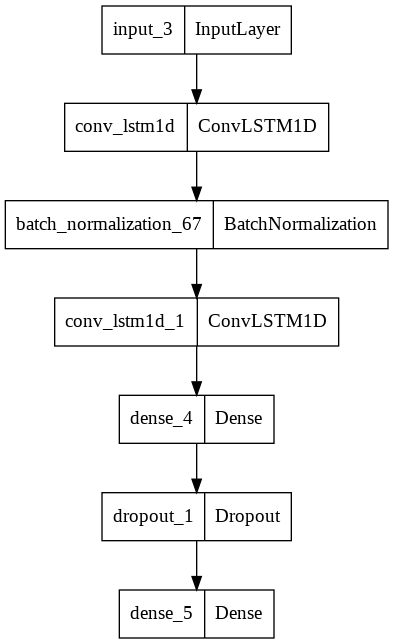

In [31]:
plot_model(convlstm_model)

In [ ]:
batchsize = 32
convlstm_model.fit(x=newsignal, y=target, batch_size=batchsize, epochs=50, verbose='auto', callbacks=None, validation_split=0.2, validation_data=(newv_signal,v_target), shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None)

In [ ]:
plt.plot(convlstm_model.history.history['accuracy'])
plt.plot(convlstm_model.history.history['Precision'])
plt.plot(convlstm_model.history.history['val_accuracy'])
plt.plot(convlstm_model.history.history['val_Precision'])
plt.legend(("accuracy","precision","val_accuracy","val_Precision"))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

In [ ]:
plt.plot(convlstm_model.history.history['loss'])
plt.plot(convlstm_model.history.history['val_loss'])
plt.legend(("loss","val_loss"))
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [ ]:
plt.plot(convlstm_model.history.history['Recall'])
plt.plot(convlstm_model.history.history['Precision'])
plt.plot(convlstm_model.history.history['AUC'])
plt.legend(("Recall","Precision","AUC"))
plt.xlabel('Epoch')

In [32]:
input_layer = Input(shape=(1000,12))
conv1 = Conv1D(filters=32,
kernel_size=8,
strides=1,
activation='relu')(input_layer)
pool1 = MaxPool1D(pool_size=4)(conv1)
lstm1 = LSTM(64)(pool1)
output_layer = Dense(1, activation='sigmoid')(lstm1)
model = Model(inputs=input_layer, outputs=output_layer)

In [33]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=[tf.keras.metrics.BinaryAccuracy(
        name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),tf.keras.metrics.Precision(name='Precision'), 
                    tf.keras.metrics.AUC(
        num_thresholds=200,
        curve="ROC",
        summation_method="interpolation",
        name="AUC",
        dtype=None,
        thresholds=None,
        multi_label=True,
        label_weights=None,
    )])

In [34]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1000, 12)]        0         
                                                                 
 conv1d_67 (Conv1D)          (None, 993, 32)           3104      
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 248, 32)          0         
 1D)                                                             
                                                                 
 lstm_2 (LSTM)               (None, 64)                24832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 28,001
Trainable params: 28,001
Non-trainable params: 0
_________________________________________________________

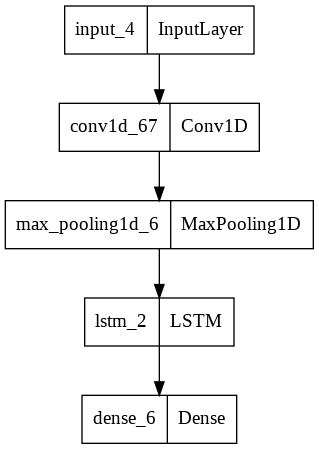

In [35]:
plot_model(model)

In [ ]:
#tf.config.run_functions_eagerly(True)

In [ ]:
batchsize = 32
model.fit(x=signal, y=target, batch_size=batchsize, epochs=50, verbose='auto', callbacks=None, validation_split=0.2, validation_data=(v_signal,v_target), shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None)

In [ ]:
plt.plot(model.history.history['accuracy'])
#plt.plot(model.history.history['Precision'])
plt.plot(model.history.history['val_accuracy'])
#plt.plot(model.history.history['val_Precision'])
plt.legend(("accuracy","precision","val_accuracy","val_Precision"))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

In [ ]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.legend(("loss","val_loss"))
plt.xlabel('Epoch')
plt.ylabel('Loss')